In [1]:
import pandas as pd
import zipfile

# Read the Excel file using pandas
df = pd.read_excel('/content/sample_data/palshi_dgr.xlsx', sheet_name='Sheet1', index_col='Date', parse_dates=True)

# Convert the index to a period index
df.index = df.index.to_period(freq='D')

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
!pip install pmdarima
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df.head()

,Turbine ID,Turbine No,KWH Export,Internal Grid Avail %,External Grid Avail %,Grid Avail %,WTG Fault Hrs..2,WTG Maintanance Hrs..2,Customer Stop Time.2,Force Major.2,...,TBA,PLF,Average W/s,No of GF/day,Generation Loss KWH,Energy loss during nearby turbine down,WTG Fault Hrs.,Customer Stop Hrs.,WTG Maintanance Hrs.,Fault Count
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,16112821,PWEPL-01,624.0,100.000000,100.0,100.000000,00:00:00,00:00:00,00:00:00,00:00:00,...,100.000000,1.625000,2.81,0,0.0,0.000000,0.0,0.0,0.000000,0
2024-01-01,16112822,PWEPL-02,412.0,100.000000,100.0,100.000000,00:00:00,00:00:00,00:00:00,00:00:00,...,100.000000,1.072917,2.78,0,0.0,0.000000,0.0,0.0,0.000000,0
2024-01-01,16112823,PWEPL-03,372.0,100.000000,100.0,100.000000,00:00:00,00:00:00,00:00:00,00:00:00,...,100.000000,0.968750,2.52,0,0.0,0.000000,0.0,0.0,0.000000,0
2024-01-01,16112824,PWEPL-04,334.0,100.000000,100.0,100.000000,00:00:00,01:01:00,00:00:00,00:00:00,...,95.763889,0.869792,2.74,0,0.0,42.932023,0.0,0.0,1.016667,0
2024-01-01,16112825,PWEPL-05,1088.0,96.736111,100.0,96.736111,00:00:00,00:00:00,00:00:00,00:00:00,...,100.000000,2.833333,2.87,1,0.0,0.000000,0.0,0.0,0.000000,0


In [4]:
df = df[['WTG Fault Hrs.','OEMA']]

In [5]:
df.head()

,WTG Fault Hrs.,OEMA
Date,,
2024-01-01,0.0,100.0
2024-01-01,0.0,100.0
2024-01-01,0.0,100.0
2024-01-01,0.0,100.0
2024-01-01,0.0,100.0


In [6]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 14652 entries, 2024-01-01 to 2024-03-31
Freq: D
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   WTG Fault Hrs.  14652 non-null  float64
 1   OEMA            14652 non-null  float64
dtypes: float64(2)
memory usage: 343.4 KB


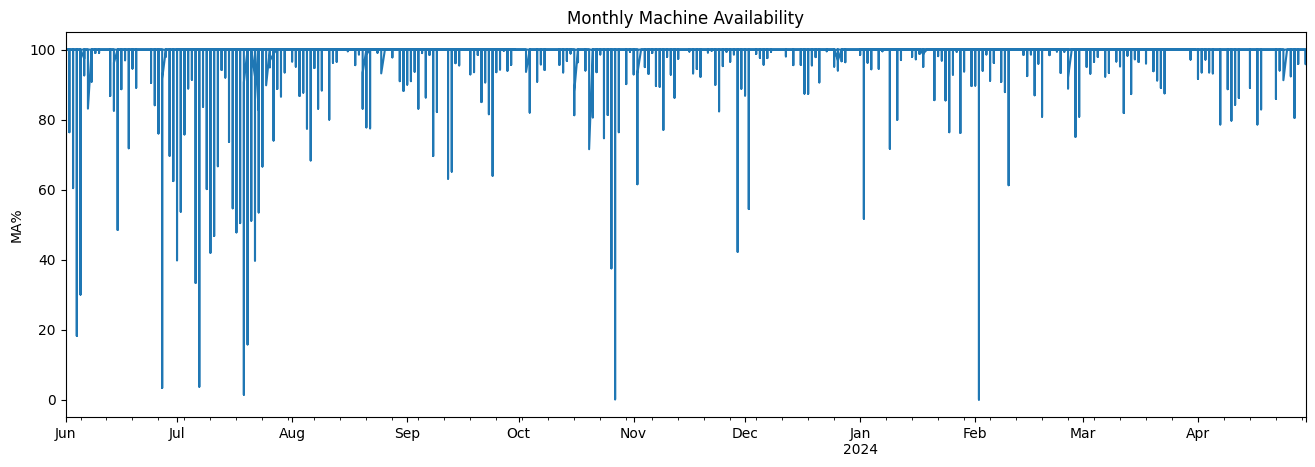

In [8]:
title='Monthly Machine Availability'
ylabel='MA%'
xlabel='' # we don't really need a label here

ax = df['OEMA'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [9]:
# Convert the index to a PeriodIndex
df.index = pd.PeriodIndex(df.index, freq='D')  # Assuming monthly frequency

# Decompose the time series
result = seasonal_decompose(df['OEMA'], period=12)

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [11]:
adf_test(df['OEMA'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -18.922023
p-value                     0.000000
# lags used                26.000000
# observations          14625.000000
critical value (1%)        -3.430797
critical value (5%)        -2.861738
critical value (10%)       -2.566875
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['OEMA'],seasonal=True,m=12).summary()